# 1st level analysis of DBS-fMRI

### Use canonical HRF and data-driven HRF

In [1]:
pip install slfmri

You should consider upgrading via the '/Users/sasha/opt/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import packages we will need
%pylab inline
import hrf_estimation as he
import pickle
import nibabel as nib
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from fmri_stats import *

# data path manager (path man~)
data_pm = PathMan('./Data')      # put all data in here
oput_pm = PathMan('./Results')   # the results will be generated here
cach_pm = PathMan('./Caches')    # all intermediate files will be saved here

Populating the interactive namespace from numpy and matplotlib


### Load BOLD data from 'Data' folder and save it to 'Cache' folder after process

In [5]:
bold_cache = cach_pm('bold_data.pkl')
if os.path.exists(bold_cache):
    with open(bold_cache, 'rb') as f:
        dict_roits, dict_brain = pickle.load(f)
else:
    dict_roits = dict()
    dict_brain = dict()

    num_init_rest_frames = 20

    # Collect BOLD data from files
    fn_ptrn = r'^scaled-(?P<subj>[0-9]{2})-(?P<stim>[0-9]{1}).*'
    for i, fname in data_pm.listdir(pattern=r'.*\.nii\.gz').items():
        mched = re.match(fn_ptrn, fname)

        if mched is not None:
            # parse info
            subj = mched['subj']
            stim = mched['stim']

            # load data
            img_nii = nib.load(data_pm(fname))
            img_dat = np.asarray(img_nii.dataobj)

            # roi mask
            roi_msk = np.nonzero(nib.load(data_pm(f'DBSM-{subj}-ROI.nii.gz')).dataobj)

            # recover lost frames during dummy scan periods
            img_dat = np.concatenate(
                [img_dat[..., :num_init_rest_frames].mean(-1)[..., np.newaxis]] * 8 + [img_dat], axis=-1)

            roi_dat = img_dat[roi_msk].mean(0)
            # baseline fitting using 'Savitzky-Golay filter' - for polynomial detrend the BOLD signal
            roi_dat -= he.savitzky_golay.savgol_filter(roi_dat, 91, 3, axis=0)  
            roi_dat -= roi_dat[:20].mean(0)

            # one subject (20) does not have 3rd epoches on 500uA stim condition
            if roi_dat.shape[0] < 700:
                epoches = 2
            else:
                epoches = 3

            # split data into each epoch
            for e in range(epoches):
                d = roi_dat[e*242:242+e*242]
                dict_roits[f'{subj}-{stim.zfill(2)}-{str(e+1).zfill(2)}'] = d
                dict_brain[f'{subj}-{stim.zfill(2)}-{str(e+1).zfill(2)}'] = img_dat[..., e*242:242+e*242]
    with open(bold_cache, 'wb') as f:
        pickle.dump((dict_roits, dict_brain), f)

### Load Dopamine signal, estimated HRF, and Max dopamine amplitudes

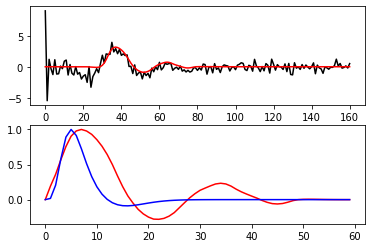

In [6]:
import pandas as pd
from slfmri.lib.signal import als_fit

# load Dopamine signals
da_data = pd.read_csv(data_pm('DopamineSignal_EstimatedHRF.csv'), header=0, index_col=0)
columns = da_data.columns.tolist()

# The colume title is names as 21-07-02.1, so update to same pattern with others.
columns[27] = '21-07-03'
da_data.columns = columns
dict_dadata = dict()
for did in dict_roits.keys():
    da_sig = np.concatenate([np.zeros(8), da_data[did].values])
    da_sig -= he.savitzky_golay.savgol_filter(da_sig, 91, 3, axis=0)    
    dict_dadata[did] = da_sig

# load HRF and estimate group-level hrf
hrfs = pd.read_csv(data_pm('HRF_all_amplitudes.csv'), header=0)
median_hrf = np.median(hrfs, axis=1)

# pre-stim data cleaning (no stimulus)
median_hrf[:2] = 0
median_hrf -= median_hrf[:33].mean(0)
# trim data (remove tail)
median_hrf[-80:] = 0
median_hrf[:33] = median_hrf[:33].mean(0)
median_hrf -= median_hrf[:30].mean(0)

estimated_hrf = als_fit(median_hrf, 5, 0.5, 100)[30:90]
estimated_hrf[0] = 0    # set zero point to zero
estimated_hrf /= estimated_hrf.max()
canonical_hrf = he.hrf.spmt(np.arange(len(estimated_hrf)))

fig, axes = plt.subplots(2, 1)
axes[0].plot(np.median(hrfs, axis=1), 'k')
axes[0].plot(als_fit(median_hrf, 5, 0.5, 100), 'r')
axes[1].plot(estimated_hrf, 'r')
axes[1].plot(canonical_hrf, 'b')

In [7]:
# Save Harry's Raw HRF (group average) and smoothed HRF

df = pd.DataFrame(dict(RawHRF=np.median(hrfs, axis=1), 
                       SmoothedHRF=als_fit(median_hrf, 5, 0.5, 100)))
df.to_excel(oput_pm('201029_for_HRF_figure.xlsx'))

### 1st level analysis
- This notebook include the code to analysis data with canonical HRF by convoluting with stimulation block

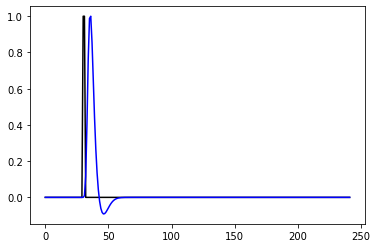

In [8]:
# Prepare model for conventional analysis to compare
pre_rest = 30
stim = 2
post_rest = 210 
stim_block = np.array([0] * pre_rest + [1] * stim + [0] * post_rest)
stim_model = np.convolve(stim_block, canonical_hrf, mode='full')[:len(stim_block)]
stim_model /= stim_model.max()

fig, ax = plt.subplots(1, 1)
ax.plot(stim_block, 'k')
ax.plot(stim_model, 'b')

# build design matrix for canonical SPM
poly = PolynomialFeatures(2)
pmodels = poly.fit_transform(np.arange(len(stim_model))[:, np.newaxis])
canonical_mmat = np.concatenate([pmodels, stim_model[:, np.newaxis]], axis=-1)
for i, m in enumerate(canonical_mmat.T):
    canonical_mmat[:, i] = m / m.max()

In [9]:
msk_nii = nib.load(data_pm('Rat_BrainMask-4slices.nii.gz'))
msk_idx = np.nonzero(msk_nii.dataobj)

for did in dict_roits.keys():
    print(f'Processing {did}', end='')
    # apply convolution and build design matrix
    estimated_bold = np.convolve(dict_dadata[did], 
                                 estimated_hrf, mode='full')[:len(stim_block), np.newaxis]
    estimated_mmat = np.concatenate([pmodels, estimated_bold], axis=-1)
    for i, m in enumerate(estimated_mmat.T):
        estimated_mmat[:, i] = m / m.max()
    
    # load data
    brain_dat = dict_brain[did]
    
    # prepare empty output images
    est_map = np.zeros(msk_nii.shape)
    can_map = est_map.copy()
    print('.', end='')
    
    # BayesianRidge regression are used. This method outperforms compare to ordinary least sqare
    # even data is noisy but slow.
    clf = BayesianRidge(compute_score=True)
    for i, t, k in np.transpose(msk_idx):
        bold_sig = brain_dat[i, t, k]
        # GLM for estimated BOLD
        clf.fit(estimated_mmat, bold_sig)
        est_map[i, t, k] = clf.coef_[-1]
        # GLM for conventional approach (SPM HRF)
        clf.fit(canonical_mmat, bold_sig)
        can_map[i, t, k] = clf.coef_[-1]
    print('.', end='')

    est_nii = nib.Nifti1Image(est_map, msk_nii.affine)
    est_nii.header['sform_code'] = msk_nii.header['sform_code']
    est_nii.header['qform_code'] = msk_nii.header['qform_code']
    est_nii.to_filename(oput_pm(f'stats_{did}_est.nii.gz'))
    print('.', end='')
    can_nii = nib.Nifti1Image(can_map, est_nii.affine, est_nii.header)
    can_nii.to_filename(oput_pm(f'stats_{did}_can.nii.gz'))
    print('Done!')

Processing 20-07-01...Done!
Processing 20-07-02...Done!
Processing 20-07-03...Done!
Processing 19-03-01...Done!
Processing 19-03-02...Done!
Processing 19-03-03...Done!
Processing 26-07-01...Done!
Processing 26-07-02...Done!
Processing 26-07-03...Done!
Processing 21-07-01...Done!
Processing 21-07-02...Done!
Processing 21-07-03...Done!
Processing 20-05-01...Done!
Processing 20-05-02...Done!
Processing 24-03-01...Done!
Processing 24-03-02...Done!
Processing 24-03-03...Done!
Processing 26-05-01...Done!
Processing 26-05-02...Done!
Processing 26-05-03...Done!
Processing 21-05-01...Done!
Processing 21-05-02...Done!
Processing 21-05-03...Done!
Processing 25-03-01...Done!
Processing 25-03-02...Done!
Processing 25-03-03...Done!
Processing 19-07-01...Done!
Processing 19-07-02...Done!
Processing 19-07-03...Done!
Processing 24-05-01...Done!
Processing 24-05-02...Done!
Processing 24-05-03...Done!
Processing 20-03-01...Done!
Processing 20-03-02...Done!
Processing 20-03-03...Done!
Processing 25-05-01.

### Move to 2nd level group statistics to continue